In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sns.set(style="whitegrid")


Dataset Shape: (6662, 3)
  label                                         email_text  \
0   ham           Hi elaine, is today's meeting confirmed?   
1   ham  Single line with a big meaning::::: \Miss anyt...   
2  spam  Unusual debit alert: Your card was used for a ...   
3   ham       I didn't get the second half of that message   
4  spam  Refund Confirmation Required\n\nYou are eligib...   

                                    email_text_clean  
0                 hi elaine todays meeting confirmed  
1  single line big meaning miss anything 4 ur bes...  
2  unusual debit alert your card was used for a p...  
3                      didnt get second half message  
4  refund confirmation requiredyou are eligible f...  

Label Distribution:
 label
ham     4536
spam    2126
Name: count, dtype: int64


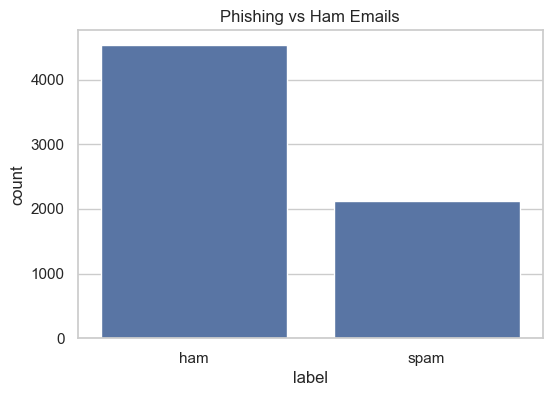

Sample rows:
0                   hi elaine todays meeting confirmed
1    single line big meaning miss anything 4 ur bes...
2    unusual debit alert your card was used for a p...
3                        didnt get second half message
4    refund confirmation requiredyou are eligible f...
5    congratulations you have been shortlisted for ...
6                               4 lets go bill millers
7                                mag meeting avo point
8    love one law make happy person love way friend...
9            another month need chocolate weed alcohol
Name: email_text_clean, dtype: object

Unique types in column:
[<class 'str'> <class 'float'>]

Empty string count:
0


In [17]:
# Load the cleaned dataset
df = pd.read_csv("../../datasets/phishing_clean_balanced.csv")

print("Dataset Shape:", df.shape)
print(df.head())

# Check label distribution
label_counts = df['label'].value_counts()
print("\nLabel Distribution:\n", label_counts)

# Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Phishing vs Ham Emails")
plt.show()
print("Sample rows:")
print(df["email_text_clean"].head(10))

print("\nUnique types in column:")
print(df["email_text_clean"].apply(type).unique())

print("\nEmpty string count:")
print((df["email_text_clean"].str.strip() == "").sum())







In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Load dataset
df = pd.read_csv("../../datasets/phishing_clean_balanced.csv")

# Clean data types
df["email_text_clean"] = df["email_text_clean"].astype(str)
df["email_text_clean"] = df["email_text_clean"].replace("nan", "")
df["email_text_clean"] = df["email_text_clean"].str.strip()

# Train TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(df["email_text_clean"])

# Save vectorizer
joblib.dump(tfidf, "backend/models/tfidf_vectorizer.pkl")

print("TF-IDF Vectorizer saved successfully.")
print("Vocabulary size:", len(tfidf.vocabulary_))


FileNotFoundError: [Errno 2] No such file or directory: 'backend/models/tfidf_vectorizer.pkl'

In [6]:
from sklearn.model_selection import train_test_split

# Features and labels
X = df['email_text_clean'].fillna("")  # use cleaned email text
y = df['label']

# Transform text to TF-IDF vectors
X_tfidf = tfidf.transform(X)

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (4093, 5000)
X_test shape: (1024, 5000)
y_train shape: (4093,)
y_test shape: (1024,)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")
    
    cr = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "model": model,
        "accuracy": acc,
        "classification_report": cr,
        "confusion_matrix": cm
    }



Training Logistic Regression...
Accuracy: 95.41%

Training Naive Bayes...
Accuracy: 97.17%

Training Linear SVM...
Accuracy: 98.24%


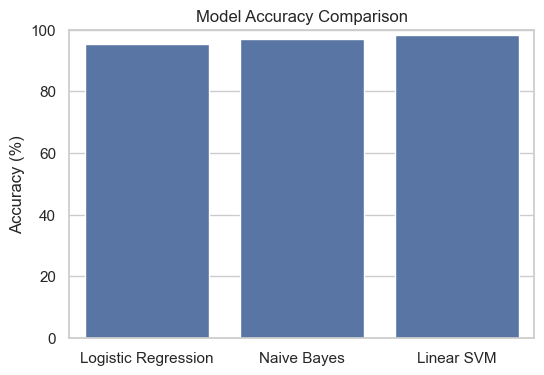

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar graph of model accuracies
plt.figure(figsize=(6,4))
sns.barplot(
    x=list(results.keys()), 
    y=[results[m]['accuracy']*100 for m in results]
)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 100)
plt.show()


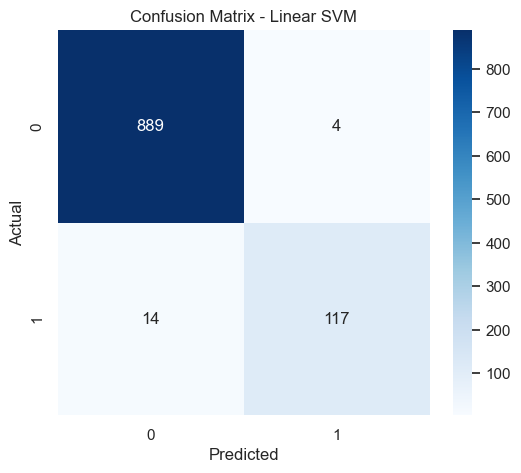


🏆 Best Model: Linear SVM with Accuracy: 98.24%


In [9]:
# Find the winner model
winner_name = max(results, key=lambda x: results[x]['accuracy'])
winner_cm = results[winner_name]['confusion_matrix']

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(winner_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {winner_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"\n🏆 Best Model: {winner_name} with Accuracy: {results[winner_name]['accuracy']*100:.2f}%")
